# Setup

In [1]:
cd /home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor

/home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from tqdm.notebook import tqdm

import utils

# Model Tuning

In [3]:
from models.numeric.arima import Arima
from utils import load_futures_data, linearize, detrend

# Load and preprocess data
data = load_futures_data()
for future in data:
    data[future] = linearize(data[future], old_var='CLOSE', new_var='CLOSE_LINEAR')
    data[future] = detrend(data[future], old_var='CLOSE_LINEAR', new_var='CLOSE_VELOCITY')
    data[future] = detrend(data[future], old_var='CLOSE_VELOCITY', new_var='CLOSE_ACCELERATION')

# Fit models
candidates = [
    Arima('CLOSE_LINEAR'),
    Arima('CLOSE_VELOCITY'),
    Arima('CLOSE_ACCELERATION'),
]

dummy = pd.Series([0, 0, 0]) # Replace endog array to save space
for candidate in candidates:
    for future in tqdm(data):        
        # Load model
        try:
            with open(f'{candidate.SAVED_DIR}/{future}.p', 'rb') as f:
                model = pickle.load(f)
        
        # Or fit a new model if it doesn't exist
        except:
            model = Arima(y_var=candidate.y_var)
            model.fit(
                data, future,
                1, 1, 1,
                4, 2, 16,
                seasonal = False,
                suppress_warnings = True,
                error_action = 'ignore',
            )
            model._fit(dummy, None) # Drop endog array before saving
        
        # Save the model
        for forecast in ('price', 'returns', 'percent'):    
            model.SAVED_DIR = model.SAVED_DIR.replace(model.forecast, forecast)
            model.forecast = forecast
            
            root = Path(model.SAVED_DIR)
            root.mkdir(parents=True, exist_ok=True)
            p = root / f'{future}.p'
            with p.open('wb') as f:
                pickle.dump(model, f)       

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

# Load Models

In [4]:
records = []
for candidate in candidates:
    root = candidate.SAVED_DIR.replace(f'/{candidate.forecast}', '')
    for forecast in ('price', 'returns', 'percent'):    
        for future in data:
            with open(f'{root}/{forecast}/{future}.p', 'rb') as f:
                records.append({
                    'model': root.split('/')[-1],
                    'forecast': forecast,
                    'future': future,
                    'arima': pickle.load(f),
                })

models = pd.DataFrame.from_records(records)
models = models.set_index(['model', 'forecast', 'future'])
models['name'] = models['arima'].apply(lambda x: str(x.model))
models.head()

arima  \
model        forecast future                                                      
CLOSE_LINEAR price    F_AD    <models.numeric.arima.Arima object at 0x7f7434...   
                      F_BO    <models.numeric.arima.Arima object at 0x7f7435...   
                      F_BP    <models.numeric.arima.Arima object at 0x7f7434...   
                      F_C     <models.numeric.arima.Arima object at 0x7f7465...   
                      F_CC    <models.numeric.arima.Arima object at 0x7f7434...   

                                                           name  
model        forecast future                                     
CLOSE_LINEAR price    F_AD     ARIMA(1,0,1)(0,0,0)[0] intercept  
                      F_BO     ARIMA(1,0,1)(0,0,0)[0] intercept  
                      F_BP     ARIMA(1,0,1)(0,0,0)[0] intercept  
                      F_C      ARIMA(1,0,2)(0,0,0)[0] intercept  
                      F_CC     ARIMA(1,0,1)(0,0,0)[0] intercept

# Model Predictions

In [ ]:
from models.numeric.model_validation import walk_forward

root = Path('model_predictions/numeric/arima')
root.mkdir(parents=True, exist_ok=True)
arima = models['arima']
    
for future in tqdm(utils.futuresList):
    p = root / f'{future}.csv'
    if not p.exists():
        windows, y_preds = walk_forward(
            model = arima['CLOSE_LINEAR', 'price', future].model,
            data = data[future]['CLOSE_LINEAR'],
            progress_bar = 'notebook',
        )
        y_preds.to_csv(p)

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/7331 [00:00<?, ?it/s]

# Load Predictions

In [21]:
y_preds = list()

for future in tqdm(utils.futuresList):
    try:
        root = Path('model_predictions/numeric/arima')
        y_pred = pd.read_csv(root / f'{future}.csv', index_col=0)
        y_pred.columns = [future]    
        y_preds.append(y_pred)
    except:
        pass

y_preds = pd.concat(y_preds)
y_preds.index = pd.to_datetime(y_preds.index)
y_preds.head()

  0%|          | 0/88 [00:00<?, ?it/s]

,F_AD,F_BO,F_BP,F_C,F_CC,F_CD
DATE,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN


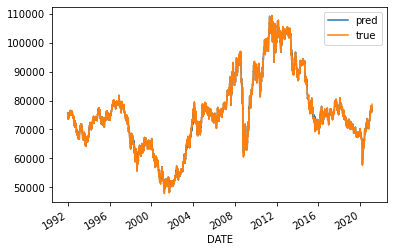

0.48840381991814463
0.49058663028649385


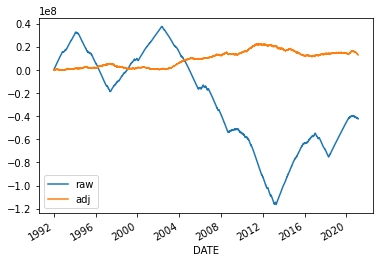

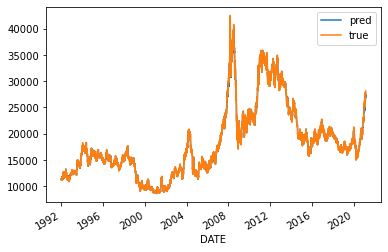

0.4858156028368794
0.4959083469721768


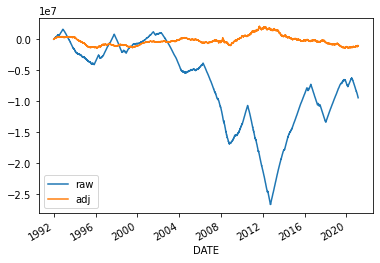

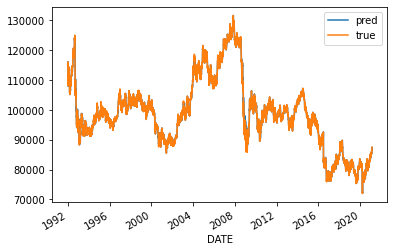

0.48636115657392254
0.4948172394980906


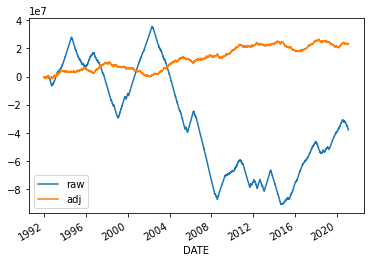

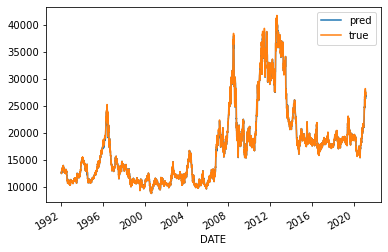

0.48098159509202454
0.487252897068848


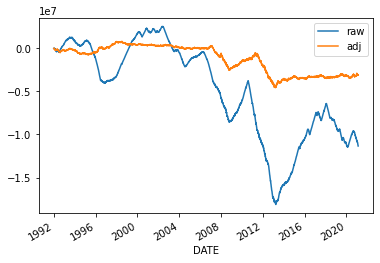

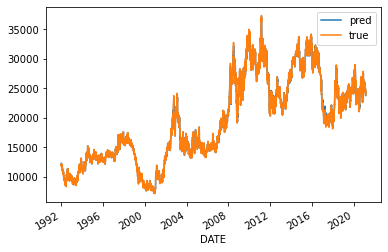

0.4738790621143562
0.47634718222953515


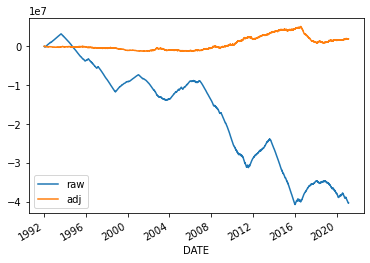

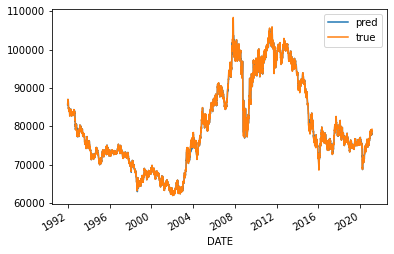

0.4879312696031638
0.4846583935633438


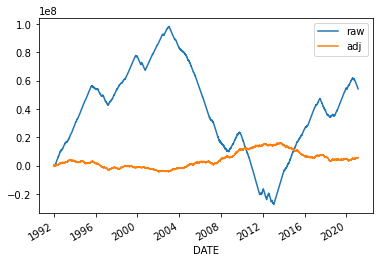

In [22]:
for future in y_preds.columns:
    y_pred = y_preds[future].dropna()
    y = data[future].loc[y_pred.index, 'CLOSE_LINEAR']
    
    y_pred = np.exp(y_pred)
    y = np.exp(y)
    
    y_pred.plot(label='pred')
    y.plot(label='true')
    plt.legend()
    plt.show()
    
    pos_pred = np.sign(y_pred - y.shift()).dropna()
    pos_true = np.sign(y.diff()).dropna()
    
    acc = pos_true == pos_pred
    adj = 2 * acc.shift().fillna(1) - 1
    
    print(np.mean(pos_pred == pos_true))    
    print(np.mean(pos_pred * adj == pos_true))
    
    (pos_pred * y).cumsum().plot(label='raw')
    (adj * pos_pred * y).cumsum().plot(label='adj')
    plt.legend()
    plt.show()

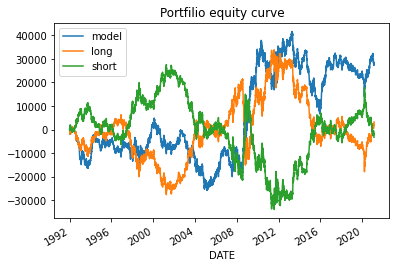

F_AD
Accuracy: 0.48840381991814463


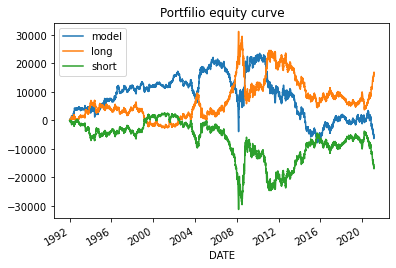

F_BO
Accuracy: 0.4858156028368794


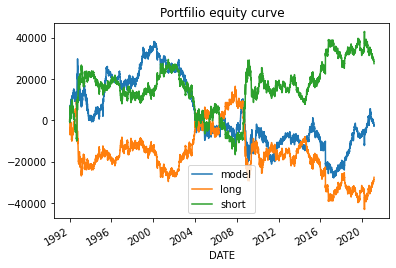

F_BP
Accuracy: 0.48636115657392254


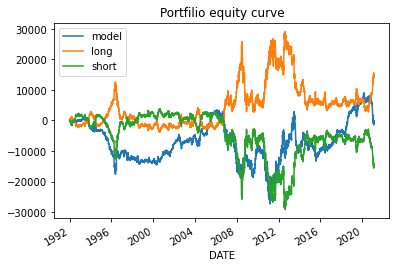

F_C
Accuracy: 0.48098159509202454


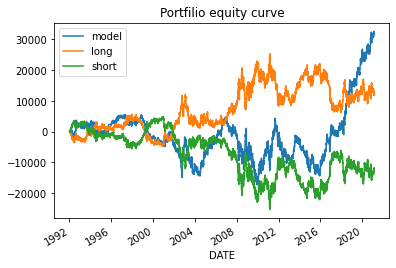

F_CC
Accuracy: 0.4738790621143562


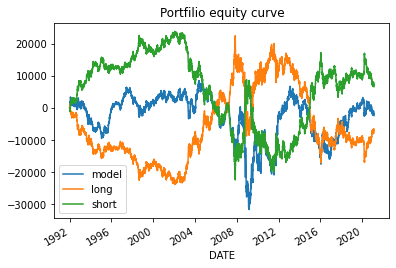

F_CD
Accuracy: 0.4879312696031638


In [23]:
for future in y_preds.columns:
    y_pred = y_preds[future].dropna()
    y = data[future].loc[y_pred.index, 'CLOSE_LINEAR']
    
    y_pred = np.exp(y_pred) - np.exp(y.shift())
    y = np.exp(y) - np.exp(y.shift())

    # Model equity curve
    returns = np.sign(y_pred) * y
    equity = returns.cumsum()

    # Benchmarks
    mask = equity.dropna().index
    optimal = y.abs().cumsum()
    long = y.cumsum()
    short = -y.cumsum()

#     y.cumsum().plot(label='market')
#     optimal.plot(label='optimal')
#     plt.title('Performance')
#     plt.legend()
#     plt.show()

    equity.plot(label='model')
    long.plot(label='long')
    short.plot(label='short')
    plt.title('Portfilio equity curve')
    plt.legend()
    plt.show()

    print(future)
    print('Accuracy:', np.mean(np.sign(y_pred[mask]) == np.sign(y[mask])))

# Predict positions

<AxesSubplot:xlabel='DATE'>

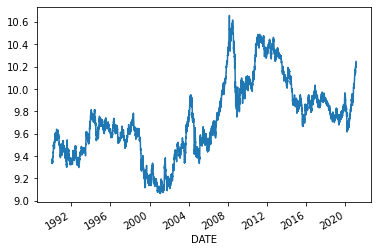

In [77]:
data['F_BO']['CLOSE_LINEAR'].plot()

In [75]:
utils.futuresList[1]

'F_BO'

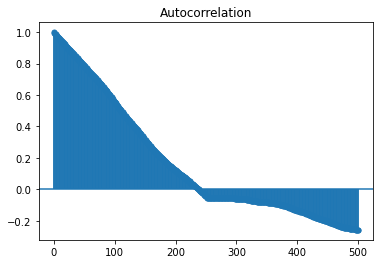

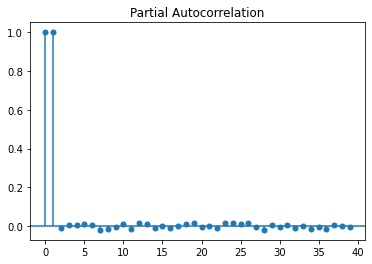

In [108]:
pm.utils.plot_acf(
    data['F_BO']['CLOSE_LINEAR'].diff(252).dropna(),
    lags=500
)

pm.utils.plot_pacf(
    data['F_BO']['CLOSE_LINEAR'].dropna(),
#     lags=500
)

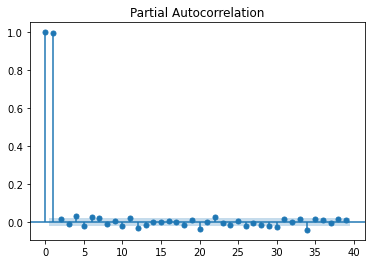

In [45]:
pm.utils.plot_pacf(
    data['F_AD']['CLOSE_LINEAR'].diff(252).dropna(),
    alpha = 0.05,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4893.681, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4903.515, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4901.521, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4901.512, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4904.834, Time=0.04 sec


  2%|▏         | 2/100 [00:00<00:05, 17.57it/s]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4899.220, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.900 seconds


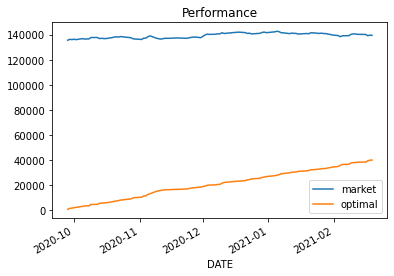

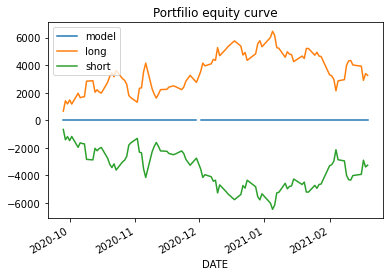

F_SF
Accuracy: 0.010101010101010102


In [164]:
sample_future = np.random.choice(utils.futuresList)
sample_data = data[sample_future]['CLOSE_LINEAR'].tail(604)
sample_model = pm.auto_arima(sample_data, seasonality=False, trace=True)

windows, y_preds = walk_forward(
    model = sample_model,
    data = sample_data,
    progress_bar = True,
)

y = np.exp(sample_data) - np.exp(sample_data.shift())
y_pred = np.exp(y_preds) - np.exp(sample_data.shift())

# Model equity curve
returns = np.sign(y_pred) * y
equity = returns.cumsum()

# Benchmarks
mask = equity.dropna().index
optimal = y[mask].abs().cumsum()
long = y[mask].cumsum()
short = -y[mask].cumsum()

np.exp(sample_data[mask]).plot(label='market')
optimal.plot(label='optimal')
plt.title('Performance')
plt.legend()
plt.show()

equity.plot(label='model')
long.plot(label='long')
short.plot(label='short')
plt.title('Portfilio equity curve')
plt.legend()
plt.show()

print(sample_future)
print('Accuracy:', np.mean(np.sign(y_pred[mask]) == np.sign(y[mask])))

# Why is R so fast???

# Data Exploration

In [4]:
data = utils.load_futures_data()

In [53]:
?fit

In [70]:
transformations = {
    'raw': lambda x: x,
    'linearize': lambda x: np.log(x),
    'detrend': lambda x: np.diff(x),
    'linearize_detrend': lambda x: np.diff(np.log(x)),
}

metrics = {
    'rsquared': lambda fit: fit.rsquared,
    'pvalue': lambda fit: fit.pvalues[1], 
}

results = pd.DataFrame(
    index = pd.MultiIndex.from_product([utils.futuresList, transformations], names=['future', 'transformation']),
    columns = metrics,
)

for future, name in tqdm(results.index):
    f = transformations[name]
    y = f(data[future]['CLOSE'])
    X = sm.add_constant(np.arange(len(y)))
    fit = sm.OLS(y, X).fit()
    
    for metric, func in metrics.items():
        results.loc[(future, name), metric] = func(fit)

results.head()

100%|██████████| 352/352 [00:00<00:00, 520.01it/s]


rsquared    pvalue
future transformation                       
F_AD   raw                0.100188       0.0
       linearize          0.093799       0.0
       detrend            0.000003  0.882197
       linearize_detrend  0.000006  0.827577
F_BO   raw                0.300287       0.0

In [87]:
import matplotlib.pyplot as plt
from pmdarima.arima import ADFTest, KPSSTest

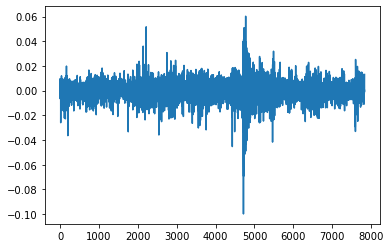

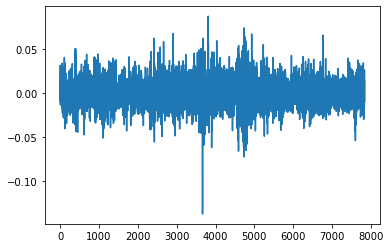

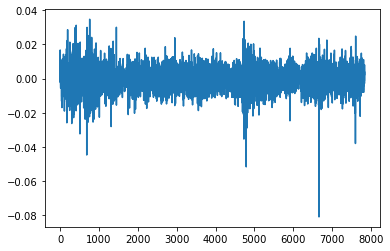

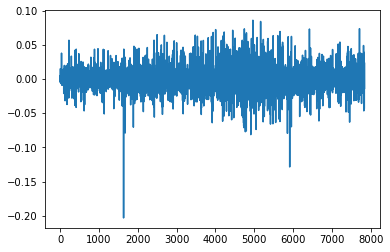

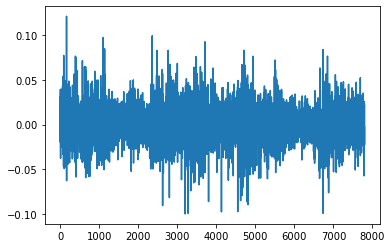

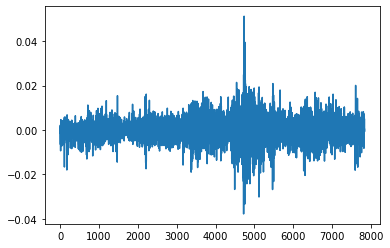

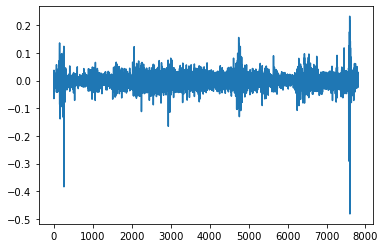

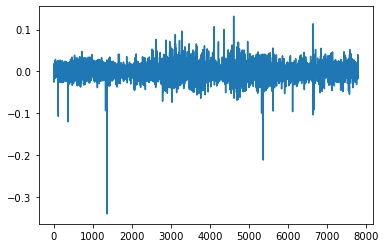

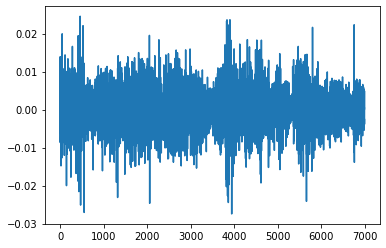

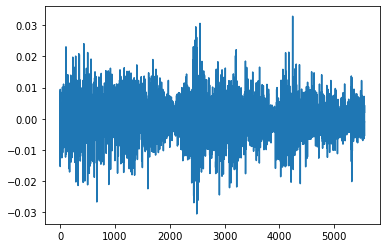

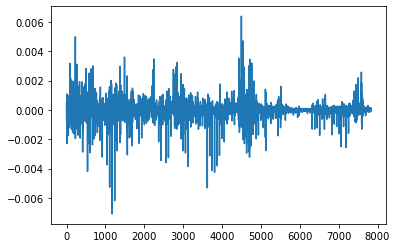

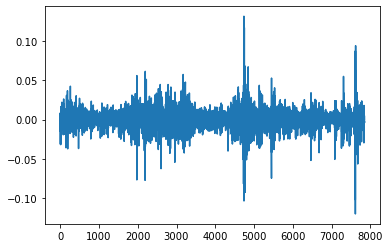

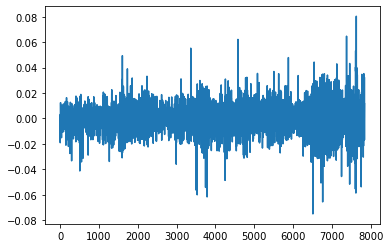

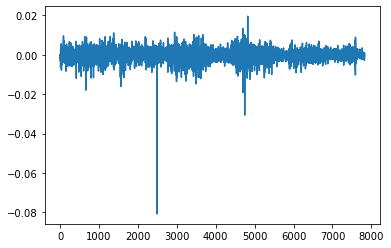

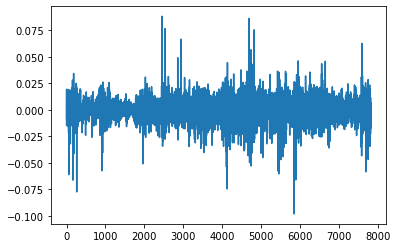

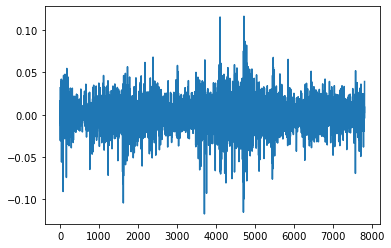

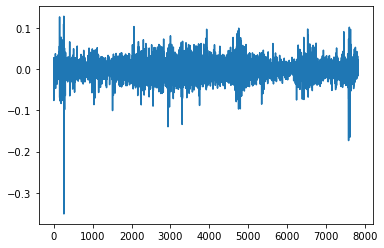

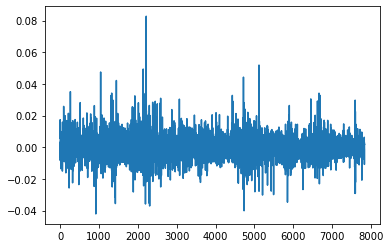

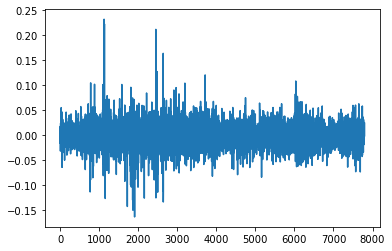

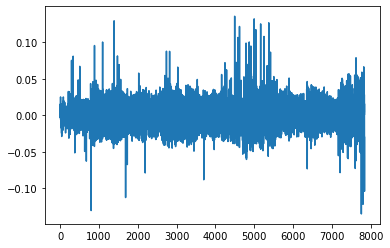

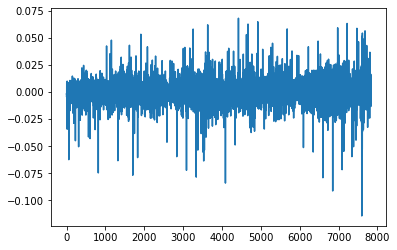

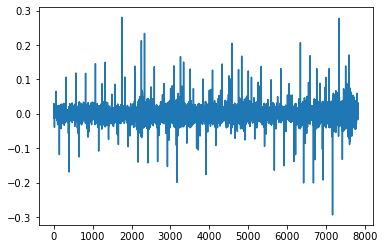

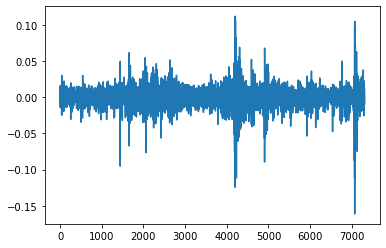

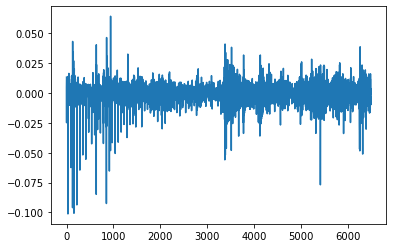

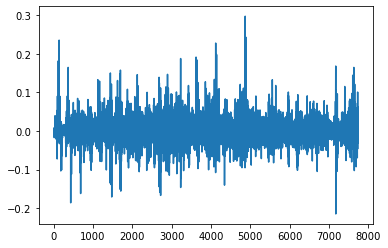

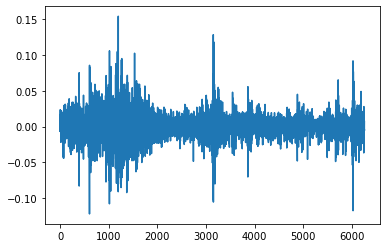

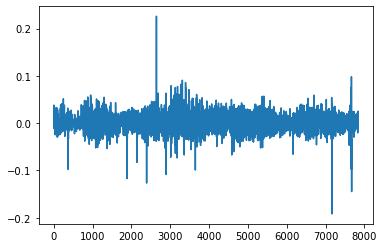

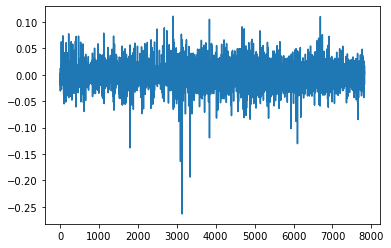

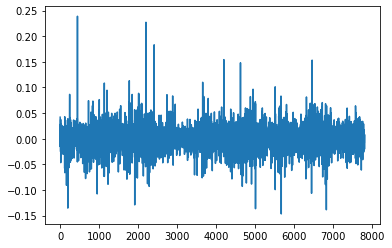

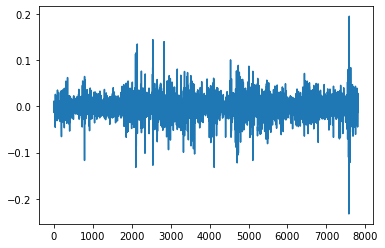

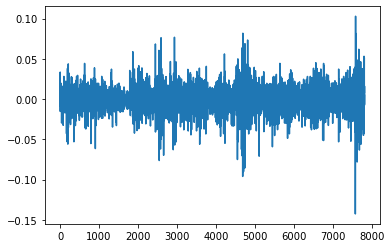

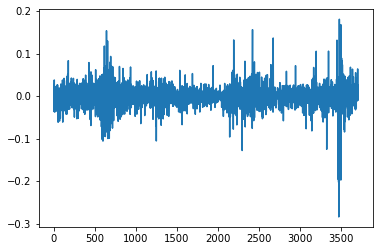

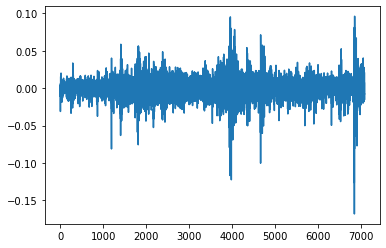

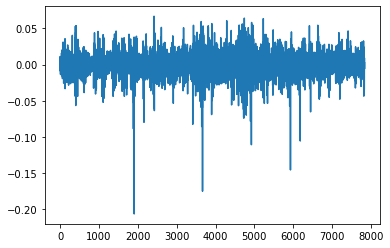

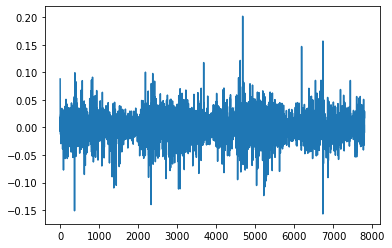

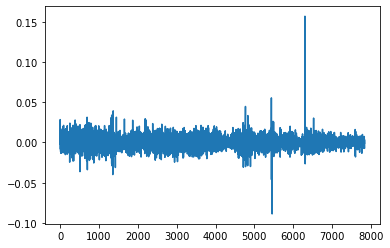

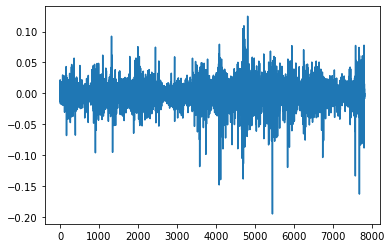

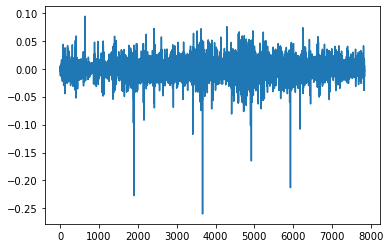

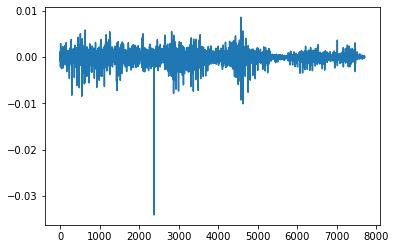

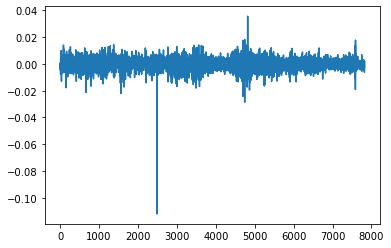

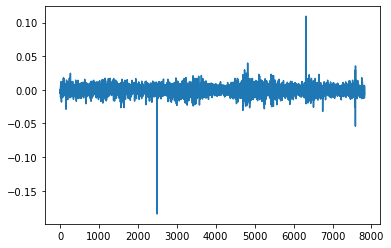

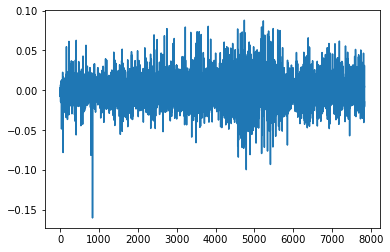

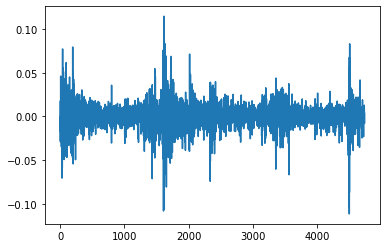

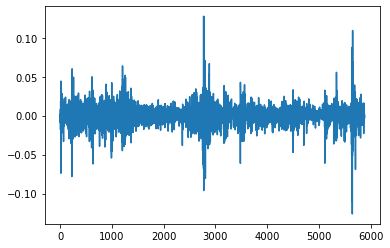

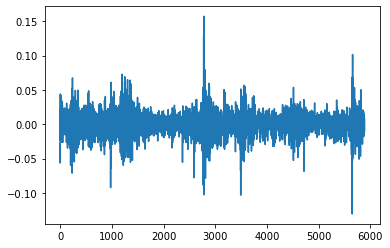

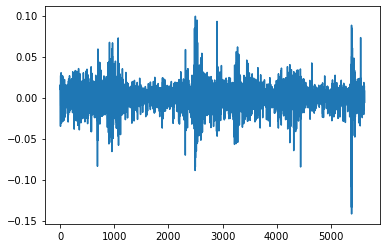

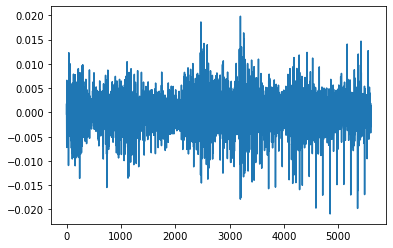

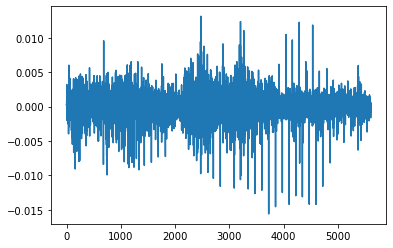

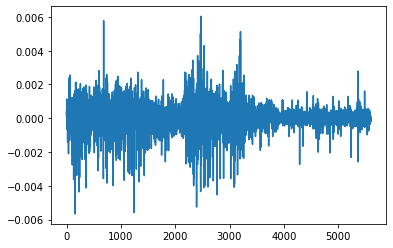

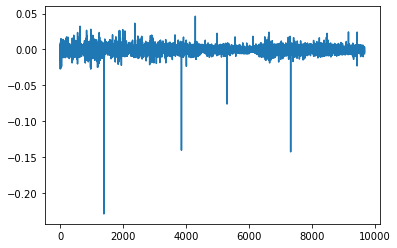

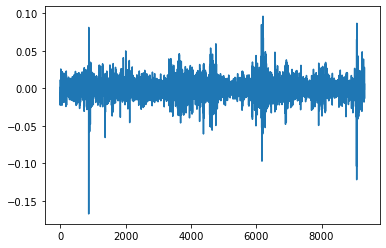

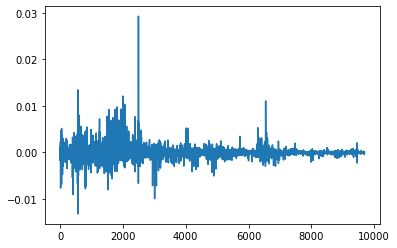

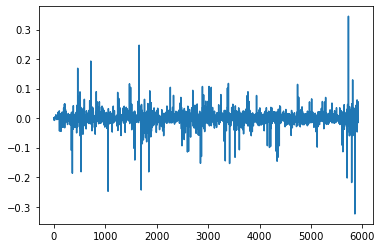

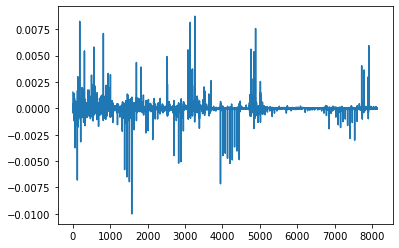

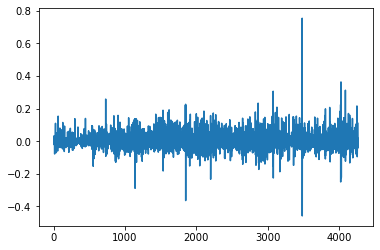

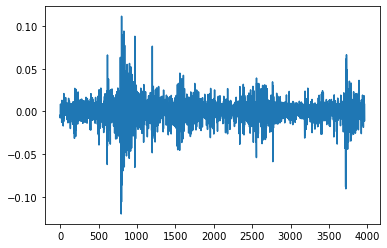

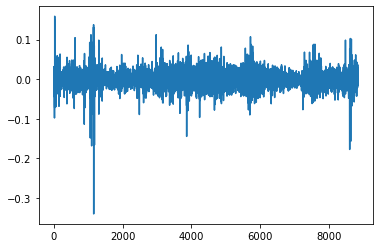

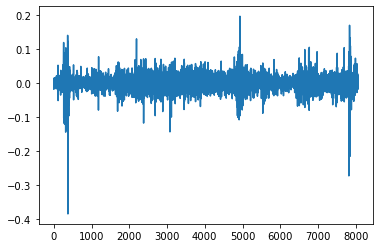

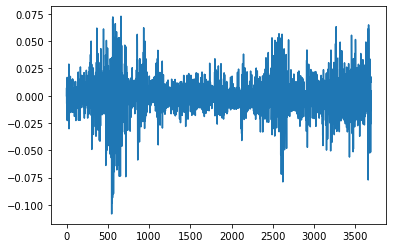

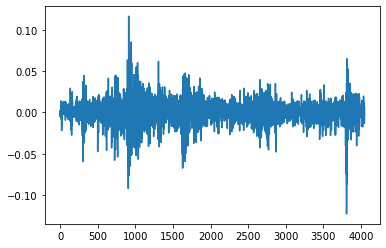

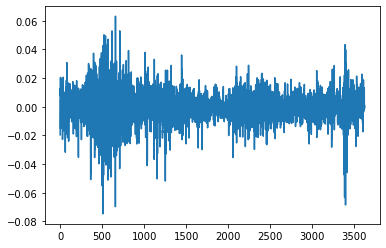

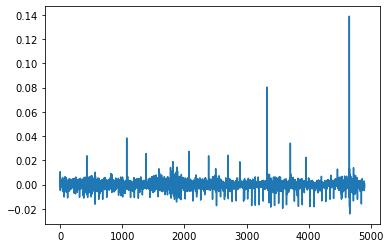

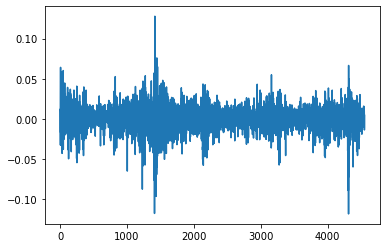

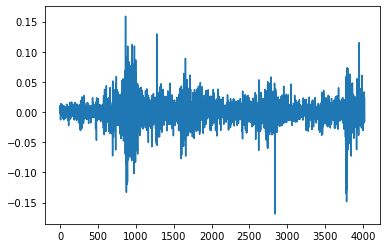

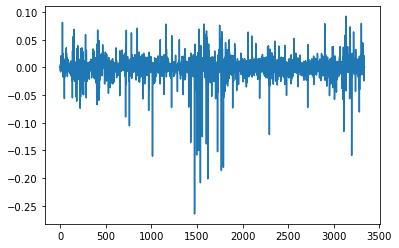

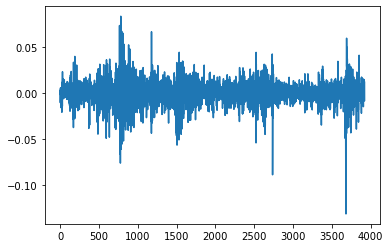

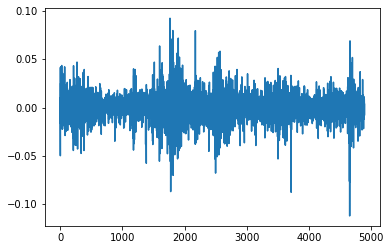

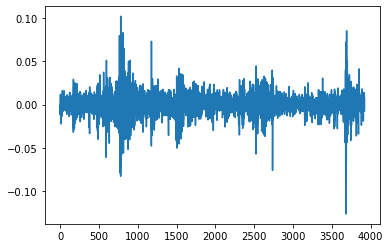

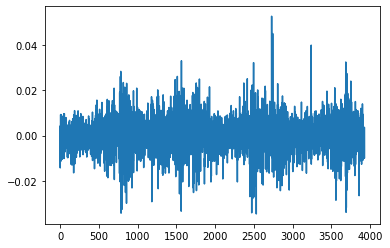

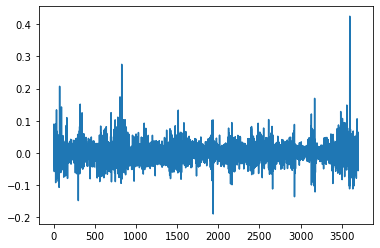

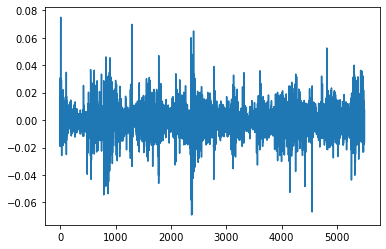

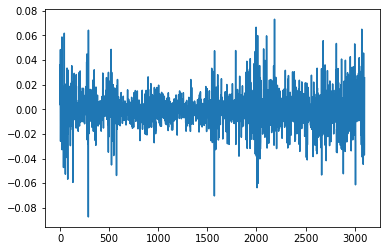

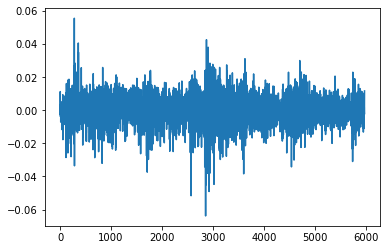

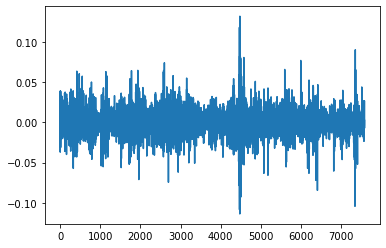

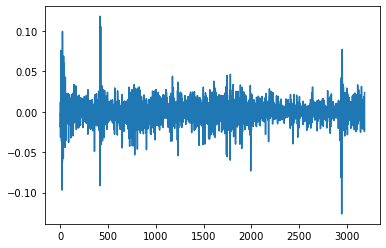

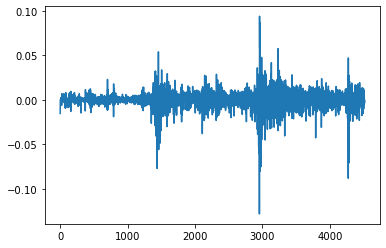

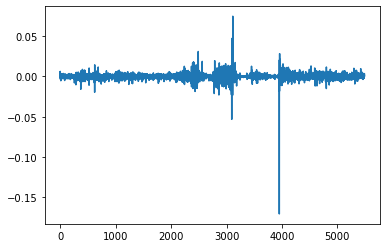

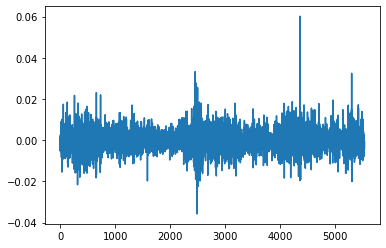

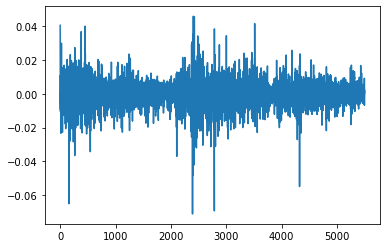

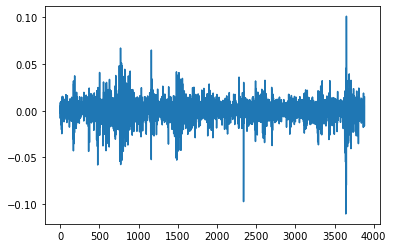

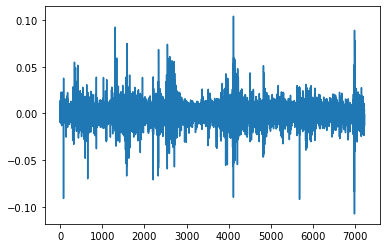

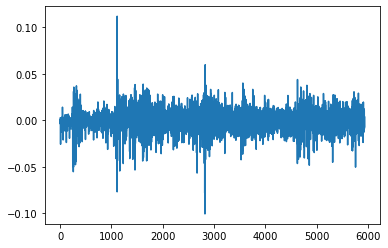

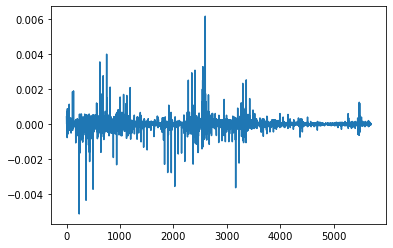

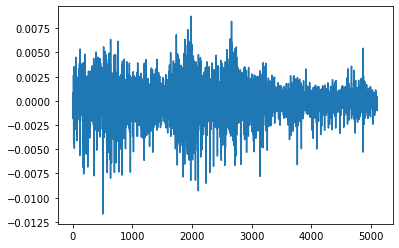

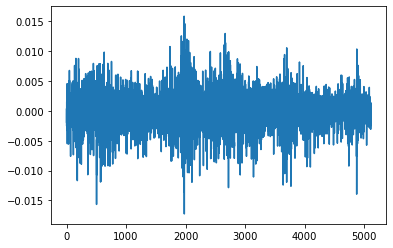

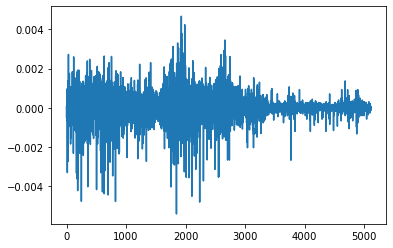

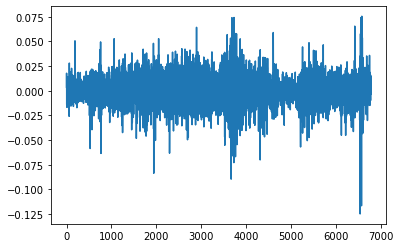

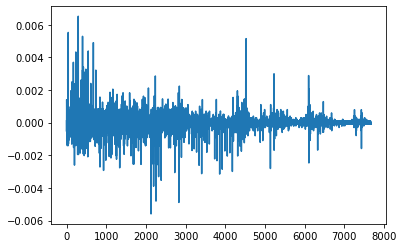

In [118]:
for future in utils.futuresList:
    pd.Series(transformations['linearize_detrend'](data[future]['CLOSE'])).plot()
    plt.show()

In [92]:
?KPSSTest

In [95]:
adf = KPSSTest(alpha=0.05)
adf.should_diff(y)

(0.1, False)

In [72]:
results.reset_index().groupby('future').max(['rsquared', 'pvalue']).transformation.unique()

array(['raw'], dtype=object)

In [ ]:
from pmdarima import AutoARIMA
from pmdarima.arima.utils import ndiffs, diff
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing.base import BaseTransformer

from sklearn.model_selection import GridSearchCV

class Linearize(BaseTransformer):
    def fit(self, y, exogenous):
        return self
    
    def transform(self, y, exogenous):
        return np.log(y)
    
class Detrend(BaseTransformer):
    def __init__(self, order=1):
        self.order = order
    
    def fit(self, y, exogenous):
        return self
    
    def transform(self, y, exogenous):
        return diff(y, difference=self.order)

Pipeline([
    ('linearize', Linearize()),
    ('detrend', Detrend()),
    ('arima', AutoARIMA(
        0, 0, 0,
        4, 0, 16,
        stationary=False, 
        seasonal=False,
    ))
])

param_grid = {
    'linearize': ['passthrough', Linearize()],
    'detrend': ['passthrough', Detrend(1), Detrend(2)],
}

In [109]:
?pm.auto_arima

In [99]:
pm.auto_arima(
    y, None,
    0, 1, 0,
    4, 2, 16,
    seasonal=False,
    information_criterion = 'aic',
    out_of_sample_size = 1,
    scoring = 'mse',
    trace = True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90205.197, Time=2.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92019.313, Time=6.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93838.557, Time=7.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90207.198, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94120.301, Time=8.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94292.959, Time=13.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92748.357, Time=9.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-93806.562, Time=23.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-94708.623, Time=13.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-94515.423, Time=24.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-94647.643, Time=46.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-94810.030, Time=72.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-94879.121, Time=15.94 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-94941.342, Time=14.27 s

/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,5)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "statsmodels/tsa/statespace/_filters/_inversions.pyx", line 411, in statsmodels.tsa.statespace._filters._inversions.dinverse_univariate
ZeroDivisionError: float division

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arim

ARIMA(order=(0, 1, 5), out_of_sample_size=1, scoring_args={},
      suppress_warnings=True)